---
title: "Practice Activity 9.2"
author: "Shiqi Wu"
format:
  html:
    self-contained: true
    embed-resources: true   
jupyter: python3
---

**Repository:** [Practice Activity 9.2](https://github.com/shiqiwu212/GSB-S544-01/tree/7bf3ed9ade1b6bcc09a4060ccf1510e6d01543ce/Week%209/Practice%20Activities/Practice%20Activity%209.2)


Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
## library imports here

In [6]:
#Set Up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [4]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [5]:
# Target: chest pain type 'cp' (0,1,2,3). Predictors: all other numeric columns.
y = ha["cp"].astype(int)
X = ha.drop(columns=["cp"]).select_dtypes(include=[np.number])

# Train/test split with stratification for multiclass
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [10]:
# Source: Chapter 18.2.1 (KNN with scaling)
knn_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=7))
])
knn_pipe.fit(X_train, y_train)
pred_knn = knn_pipe.predict(X_test)
acc_knn = accuracy_score(y_test, pred_knn)

In [11]:
# Source: Chapter 18.2.2 (Decision Tree)
tree = DecisionTreeClassifier(max_depth=4, random_state=1)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
acc_tree = accuracy_score(y_test, pred_tree)

In [12]:
# Source: Chapter 18.2.3 (LDA with scaling)
lda_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("lda", LDA())
])
lda_pipe.fit(X_train, y_train)
pred_lda = lda_pipe.predict(X_test)
acc_lda = accuracy_score(y_test, pred_lda)

print({"KNN_acc": acc_knn, "Tree_acc": acc_tree, "LDA_acc": acc_lda})

{'KNN_acc': 0.463768115942029, 'Tree_acc': 0.4782608695652174, 'LDA_acc': 0.5217391304347826}


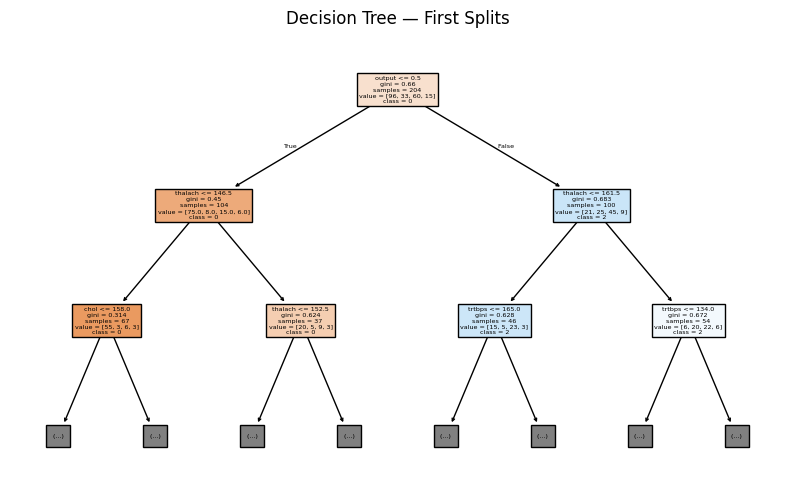

In [13]:
# Source: Chapter 18.2.2 (Plot first splits of the fitted tree)
plt.figure(figsize=(10, 6))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=[str(c) for c in sorted(y.unique())],
    filled=True,
    max_depth=2
)
plt.title("Decision Tree — First Splits")
plt.show()

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [14]:
# Source: Chapter 18.3.1 (OvR with Logistic Regression)
ovr_f1 = {}
for k in sorted(y.unique()):
    y_train_bin = (y_train == k).astype(int)
    y_test_bin  = (y_test  == k).astype(int)
    ovr_pipe = Pipeline([
        ("scale", StandardScaler()),
        ("logit", LogisticRegression(max_iter=2000))
    ])
    ovr_pipe.fit(X_train, y_train_bin)
    pred = ovr_pipe.predict(X_test)
    ovr_f1[k] = f1_score(y_test_bin, pred, zero_division=0)

print("OvR F1 by class:", ovr_f1)
best_ovr = max(ovr_f1, key=ovr_f1.get)
print("Best OvR class:", best_ovr)

OvR F1 by class: {np.int64(0): 0.6779661016949152, np.int64(1): 0.0, np.int64(2): 0.09090909090909091, np.int64(3): 0.0}
Best OvR class: 0


Answer: OvR probabilities for the four classes are not guaranteed to sum to 1, because each binary model is fit independently.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [16]:
# Source: Chapter 18.3.2 (OvO with Logistic Regression)
pairs = [(0, 1), (0, 2), (0, 3)]
ovo_auc = {}

for a, b in pairs:
    tr = y_train.isin([a, b]); te = y_test.isin([a, b])
    Xtr, ytr = X_train[tr], y_train[tr]
    Xte, yte = X_test[te],  y_test[te]

    # Binary relabel: class b as 1
    ytr_bin = (ytr == b).astype(int)
    yte_bin = (yte == b).astype(int)

    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("logit", LogisticRegression(max_iter=2000))
    ])
    pipe.fit(Xtr, ytr_bin)
    prob = pipe.predict_proba(Xte)[:, 1]

    auc = roc_auc_score(yte_bin, prob)
    ovo_auc[(a, b)] = auc

print("OvO ROC-AUC:", ovo_auc)
best_pair = max(ovo_auc, key=ovo_auc.get)
print("Best OvO pair:", best_pair)

OvO ROC-AUC: {(0, 1): 0.7897727272727273, (0, 2): 0.7440476190476191, (0, 3): 0.85625}
Best OvO pair: (0, 3)


Answer: OvO compares two classes at a time, so ROC-AUC is appropriate. OvO probabilities from different pairs do not sum to 1. With 4 classes you fit 6 pairwise models (4*3/2 = 6). In general, with K classes you fit K(K-1)/2 models.